# Time Series Analysis

## Predicting Future Values
First, we will show that $\hat{u}(t+m)$ is the minimizer of:
$$ \mathbb{E}[ \vert u(t+m) - \hat{u}(t+m) \vert^2 ] $$

In other words:
$$ \hat{u}(t+m) = \mathbb{E}[ u(t+m)\ \vert\ u(t-n), \ldots, u(t-1) ] $$

**INCOMPLETE**

## Stationary Stochastic Processes

We will compute the covariance matrices of the following stochastic system:
$$ du = -udt + dw $$

We will evaluate this system using the Euler-Marayama scheme:

In [6]:
from numpy import sqrt
from numpy.random import normal

def euler_murayama_update (
    position,           # u, float
    forcing_term,       # a, callable
    timestep,           # n, int
    timescale,          # dt, float
    chaos=1.            # used to dampen or strengthen Brownian term
):
    return position + forcing_term(timestep * timescale, position) * timescale + chaos * normal(loc=0., scale=sqrt(timescale))

Now, we define the simulation. We will keep track of the state of the system at each time step:

In [7]:
from numpy import array

def simulate_paths (
    initial_position,
    timescale=1e-2
):
    # Define useful state
    endtime = 100.
    position = initial_position
    forcing_term = lambda time, position: -position
    timesteps = int(endtime / timescale)
    # Perform EM updates and keep track of the paths through time
    states = [position] # paths at each time step
    for timestep in range(timesteps-1):
        position = euler_murayama_update(position, forcing_term, timestep, timescale)
        states.append(position)
    # Return
    return array(states)

Before we simulate, let's set some global parameters:

In [8]:
from numpy.random import seed

# Use fixed random seed
seed(1)

Now we simulate the system with several parameters:

1. When the $u(0) = 10$ with $k=0.01$:

In [9]:
path_a = simulate_paths(10., timescale=1e-2)

2. When $u(0) = 0$ with $k = 0.01$:

In [10]:
path_b = simulate_paths(0., timescale=1e-2)

3. When $u(0) = 0$ with $k=1$:

In [11]:
path_c = simulate_paths(0., timescale=1.)

Now we plot the covariances:

Text(0.5, 1, 'u(0) = 0., k = 1.')

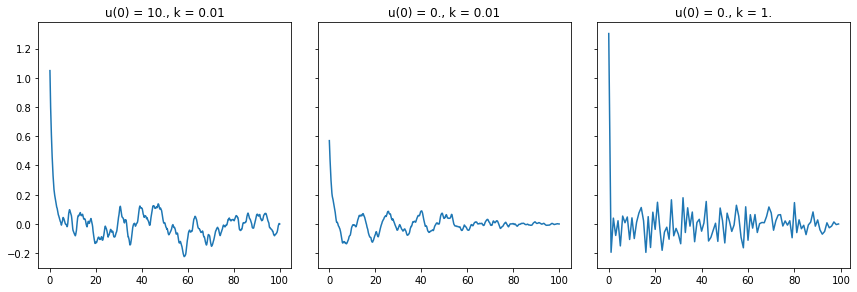

In [12]:
from matplotlib import pyplot as plt
from numpy import arange, correlate
from seaborn import lineplot

def compute_autocovariance (x, lag=0):
    x -= x.mean()
    start_idx = x.size - 1 - lag
    end_idx = start_idx + x.size
    return correlate(x, x, mode="full")[start_idx:end_idx] / x.size

# Compute covariances
cov_a = compute_autocovariance(path_a)
cov_b = compute_autocovariance(path_b)
cov_c = compute_autocovariance(path_c)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))
fig.tight_layout()
lineplot(arange(0, 100, 0.01), cov_a, ax=ax1).set_title("u(0) = 10., k = 0.01")
lineplot(arange(0, 100, 0.01), cov_b, ax=ax2).set_title("u(0) = 0., k = 0.01")
lineplot(arange(0, 100, 1), cov_c, ax=ax3).set_title("u(0) = 0., k = 1.")

## Solving Deterministic ODE
We will solve the following ODE numerically:
$$ \frac{du_i}{dt} = (u_{i+1} - u_{i-2}) u_{i-1} - u_i + F $$

Because this ODE has adjacent dependencies, it isn't trivially vectorized. Let us define an update scheme:

In [44]:
from numpy import zeros_like

def lorenz_96_update (
    state,          # state vector, N
    forcing_term    # forcing term, scalar
):
    # Zero-init solution
    result = zeros_like(state)
    # Handle edge cases
    result[0] = (state[1] - state[state.size-2]) * state[state.size-1] - state[0]
    result[1] = (state[2] - state[state.size-1]) * state[0] - state[1]
    result[state.size-1] = (state[0] - state[state.size-3]) * state[state.size-2] - state[state.size-1]
    # Handle intermediaries
    for i in range(2, state.size - 1):
        result[i] = (state[i+1] - state[i-2]) * state[i-1] - state[i]
    # Add forcing term
    result += forcing_term
    # Return
    return result

Now let us solve the ODE with $u(0) \sim \mathcal{N}(0., 1.)$ up to $t=1000$:

Text(0.5, 1.0, 'U_20')

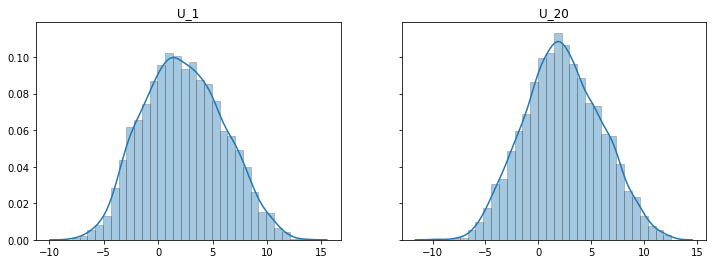

In [48]:
from numpy import arange, expand_dims
from seaborn import distplot
from scipy.integrate import odeint
from scipy.stats import entropy, gaussian_kde

# Solve the ODE
timescale = 0.1
t = arange(0, 1000, timescale)
u0 = normal(loc=0., scale=1., size=40)
u = odeint(lambda x, t: lorenz_96_update(x, forcing_term=8.0), u0, t)

# Take from t=500 to t=1000
u = u[5000:,:]
u_1 = u[:,0]
u_20 = u[:,19]

# Plot u_1 and u_20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
distplot(u_1, bins=30, kde=True, ax=ax1, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_1")
distplot(u_20, bins=30, kde=True, ax=ax2, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_20")

Let us compute the KL-divergence between $u_1$ and $u_{20}$:

In [50]:
from numpy import linspace

# Create sample grid
RANGE=[-15., 15.]
BINS = 1000
sample_grid = expand_dims(linspace(*RANGE, BINS), axis=0)

# Estimate densities
u_1_density = gaussian_kde(u_1)(sample_grid)
u_20_density = gaussian_kde(u_20)(sample_grid)

# Compute KL-div
kl_div = entropy(u_1_density, u_20_density)
print(f"KL divergence: {kl_div}")

KL divergence: 0.009421816547516355


Now, let us inspect the covariance of the process:

Text(0.5, 1.0, 'cov(u_20)')

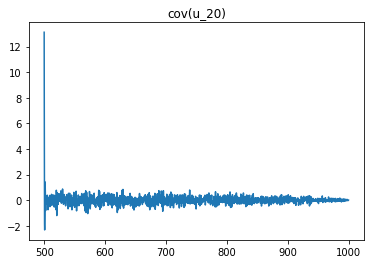

In [52]:
# Plot covariance
cov_u_20 = compute_autocovariance(u_20)
lineplot(arange(500, 1000, timescale), cov_u_20).set_title("cov(u_20)")

Finally, let us examine the spectral density $\mathcal{F}(cov(u_{20}))$:

Text(0.5, 1.0, 'spectral density cov(u_20)')

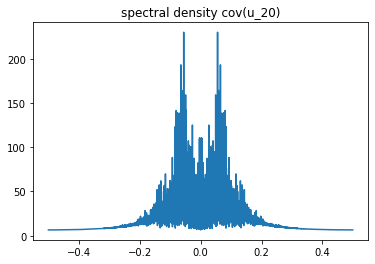

In [64]:
from numpy import abs
from numpy.fft import fft, fftfreq

spectrum = fft(cov_u_20)
magnitude = abs(spectrum)
frequencies = fftfreq(cov_u_20.size)

lineplot(frequencies, magnitude).set_title("spectral density cov(u_20)")

## Changing the Forcing Term
Let us perform the same experiment above with $F=6$:

Text(0.5, 1.0, 'U_20')

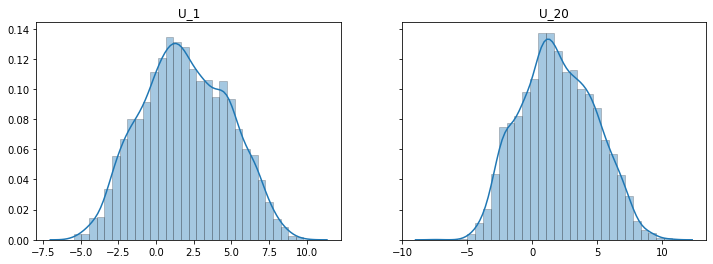

In [66]:
# Solve the ODE
timescale = 0.1
t = arange(0, 1000, timescale)
u0 = normal(loc=0., scale=1., size=40)
u = odeint(lambda x, t: lorenz_96_update(x, forcing_term=6.0), u0, t)

# Take from t=500 to t=1000
u = u[5000:,:]
u_1 = u[:,0]
u_20 = u[:,19]

# Plot u_1 and u_20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
distplot(u_1, bins=30, kde=True, ax=ax1, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_1")
distplot(u_20, bins=30, kde=True, ax=ax2, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_20")

Once again, we estimate the densities of $u_1$ and $u_{20}$:

In [67]:
# Create sample grid
RANGE=[-15., 15.]
BINS = 1000
sample_grid = expand_dims(linspace(*RANGE, BINS), axis=0)

# Estimate densities
u_1_density = gaussian_kde(u_1)(sample_grid)
u_20_density = gaussian_kde(u_20)(sample_grid)

# Compute KL-div
kl_div = entropy(u_1_density, u_20_density)
print(f"KL divergence: {kl_div}")

KL divergence: 0.0024019650921736097


Covariance:

Text(0.5, 1.0, 'cov(u_20)')

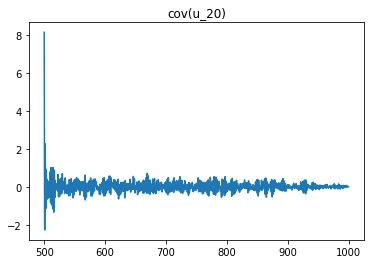

In [69]:
# Plot covariance
cov_u_20 = compute_autocovariance(u_20)
lineplot(arange(500, 1000, timescale), cov_u_20).set_title("cov(u_20)")

And finally, $\mathcal{F}(cov(u_{20}))$: 

Text(0.5, 1.0, 'spectral density cov(u_20)')

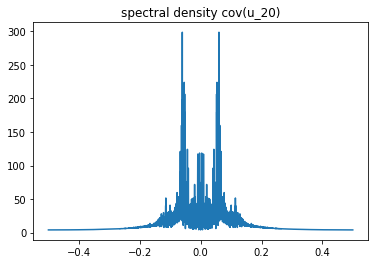

In [70]:
spectrum = fft(cov_u_20)
magnitude = abs(spectrum)
frequencies = fftfreq(cov_u_20.size)

lineplot(frequencies, magnitude).set_title("spectral density cov(u_20)")

## Predicting Stock Price

We will use stock price data [GOOG.csv](GOOG.csv):

In [55]:
from numpy import float32
from pandas import read_csv, option_context

stock_data_frame = read_csv("GOOG.csv", sep=",", parse_dates=True)
stock_data_frame

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-02-23,534.582275,534.970215,527.960510,530.453613,530.453613,1457800
1,2015-02-24,528.548889,535.320251,526.803650,534.622192,534.622192,1005000
2,2015-02-25,534.432739,544.724487,533.978943,542.380920,542.380920,1825900
3,2015-02-26,541.722717,554.617310,540.017395,553.959106,553.959106,2311500
4,2015-02-27,552.722473,563.163818,551.386169,556.871094,556.871094,2410100
...,...,...,...,...,...,...,...
1253,2020-02-13,1512.689941,1527.180054,1504.599976,1514.660034,1514.660034,929500
1254,2020-02-14,1515.599976,1520.739990,1507.339966,1520.739990,1520.739990,1197800
1255,2020-02-18,1515.000000,1531.630005,1512.589966,1519.670044,1519.670044,1120700
1256,2020-02-19,1525.069946,1532.105957,1521.400024,1526.689941,1526.689941,949300


Now, let us analyze the covariance of the closing price until Dec 31, 2019:

Text(0.5, 1.0, 'covariance closing prices up to Dec 31 2019')

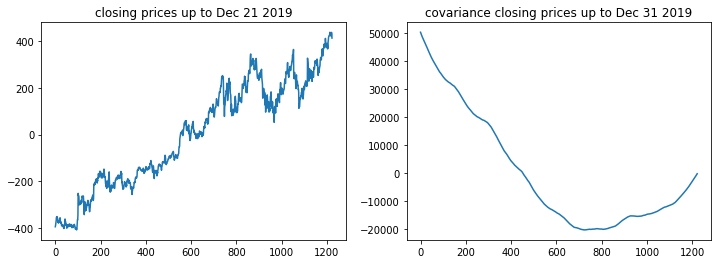

In [56]:
# Get the index of the cutoff date in the frame
cutoff_date = "2019-12-31"
cutoff_index = stock_data_frame.index[stock_data_frame["Date"] == cutoff_date].tolist()[0]

# Get data and plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
closing_prices = stock_data_frame["Close"].to_numpy()[:cutoff_index]
covariance = compute_autocovariance(closing_prices)
lineplot(arange(0, closing_prices.size), closing_prices, ax=ax1).set_title("closing prices up to Dec 21 2019")
lineplot(arange(0, closing_prices.size), covariance, ax=ax2).set_title("covariance closing prices up to Dec 31 2019")

This autocovariance looks spurious, as the covariance should never be negative (the stock price never becomes negative).

Now, we will use the covariance function to make predictions for prices after Dec 31. We will be using an autoregressive model:
$$ \hat{u}(t + m) = \sum_j a_j u(t - j) $$

And as shown in the notes, we can find the optimal $\vec{a}$ as:
$$ R(j - k) \vec{a} = R(m + j) $$

Where the columns of the covariance matrix $R(j - k)$ are the covariance of the time series with lag $j = 0\ldots n$. And $R(m + j)$ is the predicted covariance of the time series. We will apply the model iteratively, hence we will set $m=1$ and use this to predict daily prices. In order to compute the predicted $R(m+j)$, we will assume that the process is stationary, hence its covariance at lag $j$ should not change at lag $j + m = j + 1$. This gives us a linear system we can solve:

In [62]:
from numpy import append, array
from numpy.linalg import solve

def autoregressive_prediction (series):
    # First, build the covariance matrix
    covariance_matrix = array([compute_autocovariance(series, lag=i) for i in range(series.size)])
    # Then compute our expected future covariance by using lag 1
    expected_covariance = compute_autocovariance(series, lag=-1)
    expected_covariance = append(expected_covariance, expected_covariance[-1:])
    # Solve the linear system
    a_optimum = solve(covariance_matrix, expected_covariance)
    # Apply the linear model
    return series @ a_optimum

Now, we can predict stock prices for the rest of the year:

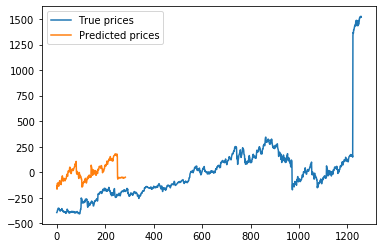

In [64]:
predict_days = 33

# Iteratively make one-day predictions
series = closing_prices
for i in range(predict_days):
    next_day_prediction = autoregressive_prediction(series)
    series = append(series, [next_day_prediction])

# Plot original stock price against prediction
true_prices = stock_data_frame["Close"].to_numpy()
lineplot(arange(0, true_prices.size), true_prices, legend="brief", label="True prices")
lineplot(arange(0, series.size), series, legend="brief", label="Predicted prices")

These results don't look convincing, and it is likely caused by the autocorrelation being negative at certain points.

## Shorter-Term Prediction

Now we will make a prediction using only data from Jan 1 2019 to Dec 31 2019:

Text(0.5, 1.0, 'covariance closing prices up to Dec 31 2019')

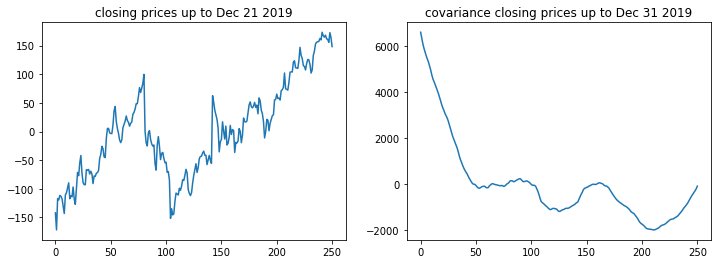

In [59]:
# Get the index of the start date in the frame
start_date = "2019-01-02" # 1st of Jan isn't in the dataset
start_index = stock_data_frame.index[stock_data_frame["Date"] == start_date].tolist()[0]

# Get data and plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
closing_prices = stock_data_frame["Close"].to_numpy()[start_index:cutoff_index]
covariance = compute_autocovariance(closing_prices)
lineplot(arange(0, closing_prices.size), closing_prices, ax=ax1).set_title("closing prices up to Dec 21 2019")
lineplot(arange(0, closing_prices.size), covariance, ax=ax2).set_title("covariance closing prices up to Dec 31 2019")

And let's predict:

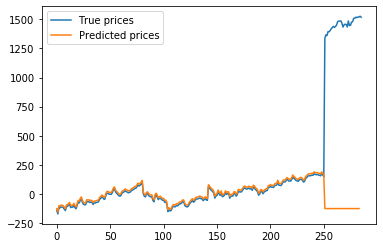

In [60]:
predict_days = 33

# Iteratively make one-day predictions
series = closing_prices
for i in range(predict_days):
    next_day_prediction = autoregressive_prediction(series)
    series = append(series, [next_day_prediction])

# Plot original stock price against prediction
true_prices = stock_data_frame["Close"].to_numpy()[start_index:]
lineplot(arange(0, true_prices.size), true_prices, legend="brief", label="True prices")
lineplot(arange(0, series.size), series, legend="brief", label="Predicted prices")

## Improving Performance
The autoregressive model assumes that the covariance will achieve a steady state. While this is true for strict stationary processes, we can't make the same assumption for stock prices. Also, the stock price sees a jump in early 2020, which cannot be predicted using past behaviour. A more powerful model will need more than just stock prices, and will likely need to be highly non-linear (did someone say 'machine learning'?).